# Using Word2Vec Embedding to extend POC Guesser

We can use Gensim to make a more powerful version of our Proof-of-Concept. The main limitation will be guesses that lie outside of the training corpora; we might tackle this later with FastText. For now, let's see if we can make less of a toy version using the Google News Skip-Gram model with 300-feature embeddings (requires ~2GB).

Make sure to update SSL Certificate to download if required: 
```
pip install -U certifi

/Applications/Python 3.X/Install Certificates.command
```

In [13]:
import os
import gensim
import gensim.downloader
import gensim.models

saved_path_name = "word2vec-google-news-300_c"
limit = 200_000

if not os.path.exists(saved_path_name):
    print("Checking cache and downloading")
    google_news_wv = gensim.downloader.load("word2vec-google-news-300")
    google_news_wv.save_word2vec_format(saved_path_name)
    print("Saved to disk in C format")
    del google_news_wv

print(f"Loading {limit} from saved")
google_news_wv = gensim.models.KeyedVectors.load_word2vec_format(saved_path_name, limit=limit)

Loading 200000 from saved


In [14]:
print(len(google_news_wv.index_to_key))
for index, word in enumerate(google_news_wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(google_news_wv.index_to_key)} is {word}")

200000
word #0/200000 is </s>
word #1/200000 is in
word #2/200000 is for
word #3/200000 is that
word #4/200000 is is
word #5/200000 is on
word #6/200000 is ##
word #7/200000 is The
word #8/200000 is with
word #9/200000 is said


Let's see if the model has each of our official words

In [15]:
import decryptogame as dg

for word in dg.official_words.english.words:
    if word.lower() not in google_news_wv:
        print(word)

SCIENCE-FICTION
FRANCE
CYCLOPS
EGYPT
EXTRA-TERRESTRIAL
CALENDA
GERMANY
QUEBEC
PEGASUS
ARMOUR
CENTAUR
AFRICA
RUSSIA
SLAUGHTER-HOUSE
THEATRE
MOUSTACHE


I suspect this may just be a matter of capitalization, formatting, and British spellings. Let's see if we can make a mapping; if not we can use the weak linearity of Word2Vec. 

In [16]:
def official_keyword_to_word(keyword: str):
    typos = { "CALENDA": "calendar"}
    if keyword in typos:
        return typos[keyword]
    proper_nouns = [
        "AFRICA",
        "CENTAUR",
        "CYCLOPS",
        "EGYPT",
        "FRANCE",
        "GERMANY",
        "PEGASUS",
        "QUEBEC",
        "RUSSIA"
    ]
    if keyword in proper_nouns:
        return keyword.capitalize()
    british = {
        "ARMOUR": "armor",
        "MOUSTACHE": "mustache",
        "THEATRE": "theater",
    }
    if keyword in british:
        return british[keyword]
    if '-' in keyword:
        if keyword == "SCIENCE-FICTION":
            keyword = keyword.replace('-', '_')
        keyword = keyword.replace('-', '')
    return keyword.lower()

all_included = False
for keyword in dg.official_words.english.words:
    if official_keyword_to_word(keyword) not in google_news_wv:
        print(keyword)
        all_included = True
if not all_included:
    print("Gonna have to improvise")
print("Done!")





Gonna have to improvise
Done!


Looks like we don't need to improvise! Let's see what the keywords the creators chose look like using t-SNE

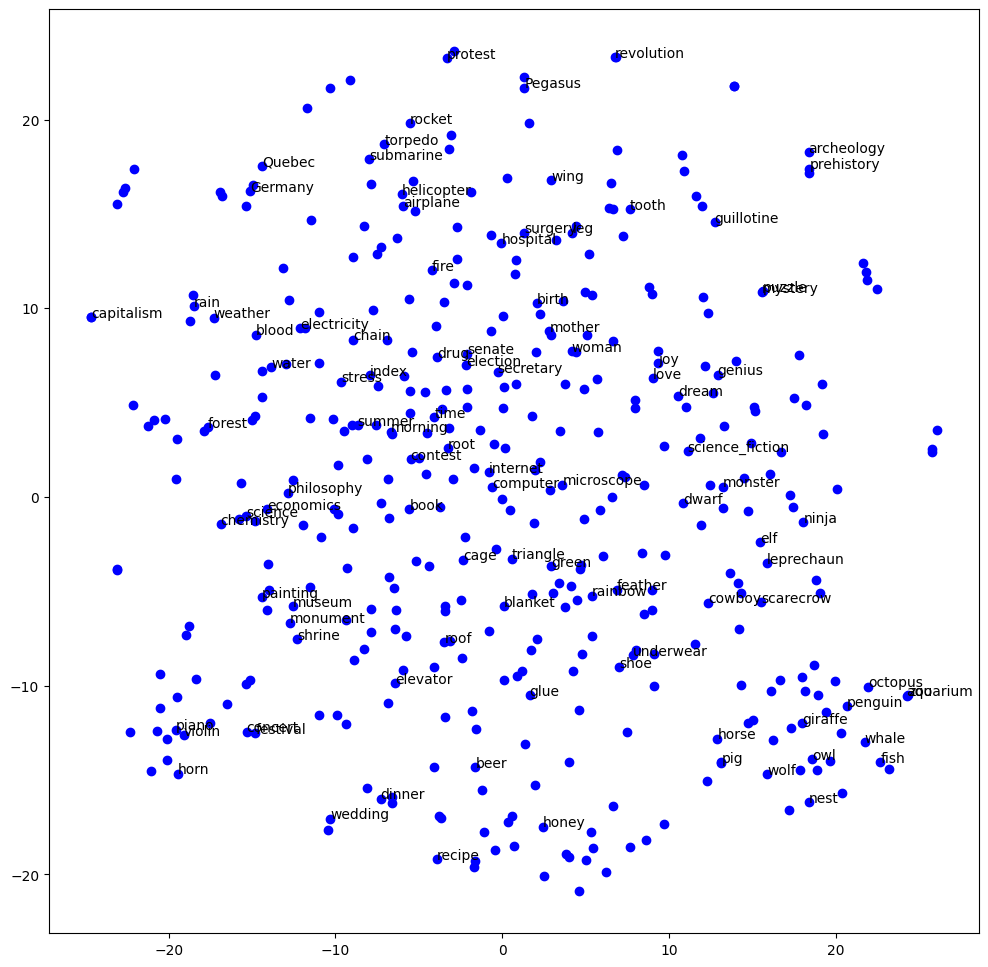

In [35]:
# inspired by https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling
import matplotlib.pyplot as plt
import random

random.seed(400)

official_words = [official_keyword_to_word(word) for word in dg.official_words.english.words]
official_vectors = np.asarray([google_news_wv[word] for word in official_words])

# reduce using t-SNE
num_dimensions = 2
tsne = TSNE(n_components=num_dimensions, random_state=0)
tsne_official_vectors = tsne.fit_transform(official_vectors)
official_x_vals, official_y_vals, *_ = zip(*tsne_official_vectors) # x has v[0] for each vector, y has v[1]

def plot_with_matplotlib(fig, ax, x_vals, y_vals, labels, num_show=100, color="b"):
    
    ax.scatter(x_vals, y_vals, color=color)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, num_show)
    for i in selected_indices:
        ax.annotate(labels[i], (x_vals[i], y_vals[i]))

fig, ax = plt.subplots(figsize=(12, 12))
plot_with_matplotlib(fig, ax, official_x_vals, official_y_vals, official_words)


How do the words compare to words in the general corpus? I predict it will be clustered because although they may have tried to choose dissimilar words, the words are almost all nouns and share a similar type; furthermore, the creators also probably didn't choose extremely rare words.

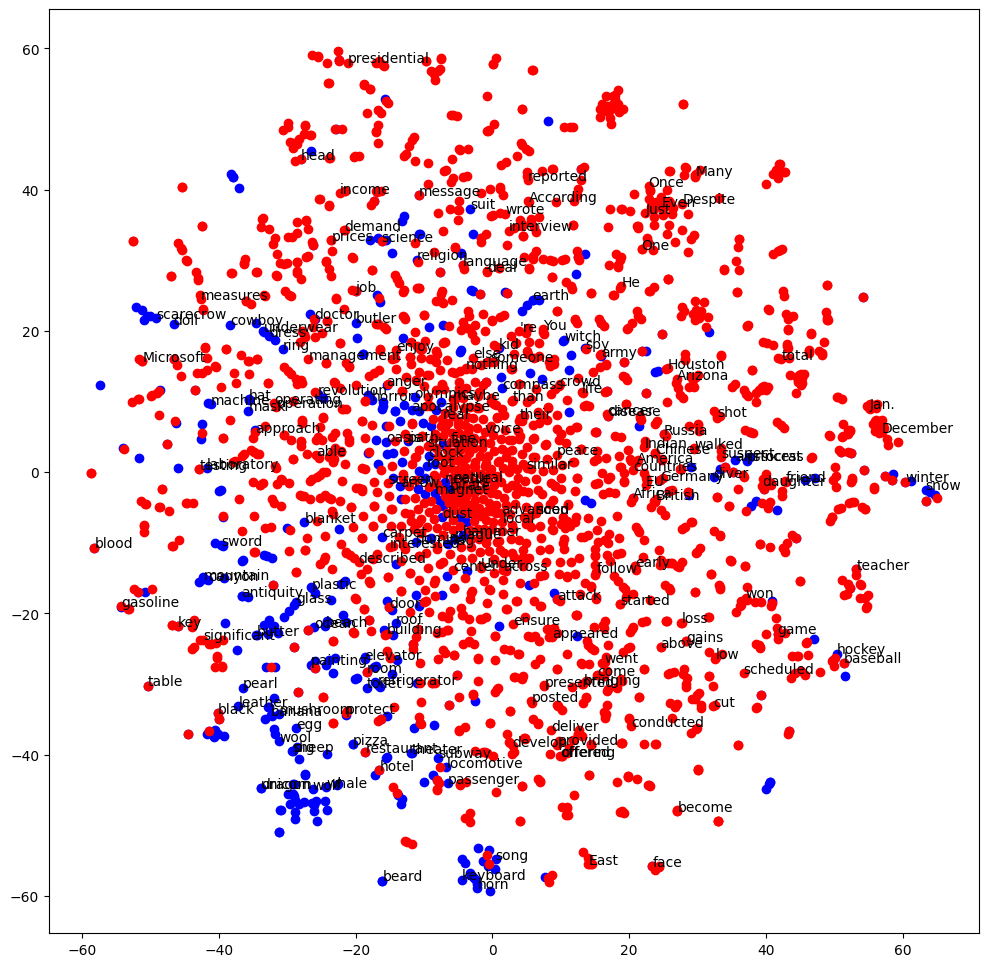

In [52]:

google_words = [word for word in google_news_wv.index_to_key[:2000]]
google_vectors = np.asarray([google_news_wv[word] for word in google_words])

# reduce using t-SNE
tsne = TSNE(n_components=num_dimensions, random_state=0)
both_vectors = np.concatenate((official_vectors, google_vectors))
tsne_both_vectors = tsne.fit_transform(both_vectors)
x_vals, y_vals, *_ = zip(*tsne_both_vectors) # x has v[0] for each vector, y has v[1]
official_x_vals, official_y_vals = x_vals[:len(official_vectors)], y_vals[:len(official_vectors)]
google_x_vals, google_y_vals = x_vals[len(official_vectors):], y_vals[len(official_vectors):]

fig, ax = plt.subplots(figsize=(12, 12))
plot_with_matplotlib(fig, ax, official_x_vals, official_y_vals, official_words)
plot_with_matplotlib(fig, ax, google_x_vals, google_y_vals, google_words, color="r")

The words are actually a lot less clustered than I thought they would be.

The most striking thing is the sidedness; I think this corresponds to the prediction I made based off of the noun hypothesis, as evidenced by the lack of official words near verbs.

One interesting thing to notice is that a lot of words are seprated from the official words by a large margin; perhaps such words could be used to highly throw off an opposing intercepter.
On the other hand, for official words that are outliers, using closely related words will leak a lot more information. Words like hockey seem a lot worse to get than scarecrow and doll because there are fewer similar official words to them.

Another interesting thing to notice is that the official words are actually less clumped than the most common words in the model; perhaps this asymmetry could be taken advantadge of?